# README

This delivery contains the implementation of the 8th task of the "Automatic Signal Detector" project of the Computer Vision course.

In this notebook we test the models trained in tasks 7 and 9. The current version of the model is trained to detect the letters "A", "B" and "C". For more information please check following [sign language alphabet](https://en.wikipedia.org/wiki/Fingerspelling#/media/File:Asl-sign-language-coloring-at-coloring-pages-for-kids-boys-dotcom.svg)

The last cell of the notebook needs of the following interaction with the user:


1.   Firstly, it will ask the user to choose between the model trained in task 7 (**cnn**) or the model trained in task 9 (**vgg**)

2.   Sencondly, the user must show his hand on camera and the script will ask to **confirm if the bounding box correctly detected the hand**.

3.  Once it is confirmed, the script will show the predicted letter **in screen**.

In order to run succesfully, one must download the harcascade from 

*   https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

Import them in their own drive and change the path in the "Synchronizing drive files section"

## Important notes:

1.   The cells that use the webcam run in a loop, one has to **stop manually the cell** and **re-run the notebook from the next cell** to run the rest of the notebook successfully.

# TASK 8 - MACHINE LEARNING AND COMPUTER VISION PROJECT

Author: Nicolás Arrieta Larraza

Date: 03/05/2021

## Initializing

### Importing libraries

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import io
import cv2 # OpenCV library
from pathlib import Path
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
cv2.__version__

'4.1.2'

### Synchronizing Drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Specifying face cascade's path

In [ ]:
# Change for custom location
face_cascade_path = "/content/drive/MyDrive/UCA/ComputerVision/task_1/haarcascade_frontalface_default.xml"

Specifying the paths of the models from task 7 and 9

In [ ]:
cnn_model_path = "/content/drive/MyDrive/UCA/ComputerVision/task_7/custom_model.h5"
vgg_model_path = "/content/drive/MyDrive/UCA/ComputerVision/task_9/vgg_model.h5"

### Importing the cascade filter to OpenCV

In [ ]:
face_cascades = cv2.CascadeClassifier(face_cascade_path)

## Defining functions

Function to capture video from computer webcam trough the web browser (given)

In [ ]:
from google.colab.output import eval_js

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

Functions to convert base64 to bytes array format and viceversa (given). These functions are necessary since the images in Javascript work with base64 format and OpenCV works with bytes array.

In [ ]:
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

Function to plot histogram of colors

In [ ]:
def show_hist(hist):
  bin_count = hist.shape[0]
  bin_w = 24
  img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
  for i in range(bin_count):
      h = int(hist[i])
      cv2.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  cv2_imshow(img)

Function to compute face recognition

In [ ]:
def detect_faces(img, cascades):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = cascades.detectMultiScale(gray, 1.3, 4)
  return faces

Function to scale a rotated box by a factor. It is used to scale up the bounding box to remove the noise in the edges of the rectangle.

In [ ]:
def scale_contour(pts, scale_x, scale_y):
    M = cv2.moments(pts)

    if M['m00'] == 0:
      return pts

    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = pts - [cx, cy]
    cnt_scaled = cnt_norm * np.array([scale_x, scale_y])
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

Function to create box arounf CAM Shift resulting box


In [ ]:
def get_hand_box(pts, im_w, im_h):
  x_top_l = max(0, min(pts[:,0]))
  y_top_l = max(0, min(pts[:,1]))
  x_bottom_r = min(im_w, max(pts[:,0]))
  y_bottom_r = min(im_h,  max(pts[:,1 ]))
  return (x_top_l, y_top_l), (x_bottom_r, y_bottom_r)

## Capturing region of the recognized faced

First, we need to capture a frame of a face in order to compute it's histogram

In [ ]:
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")

  # Detecting faces
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  im_copy = im.copy()
  faces = detect_faces(im, face_cascades)

  # Drawing a green rectangle in face's region
  if len(faces) == 1:
    face = faces[0]
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue
  # Showing capture
  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy)))
  response = input("Use this bounding box? [y or n]:")
  # We offer the user the option to keep the previous frame or redo it
  if response == 'y':
    # In case of accepting we show the selected face frame
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    # Asign it to the tracking window variable that will be use in next steps
    tracking_window_face = face
    break

im = im

<IPython.core.display.Javascript object>

Type anything when ready!:f
Use this bounding box? [y or n]:y


## Building histogram from detected face

We compute the histogram of color (only HUE channel) of the face region in order to "back project" it in the entire region. Then we check fro every pixel in the image the probability of its color to be part of the histogram. Therefore, the parts of the body with similar colors will show also high probability like arms, hands, etc.

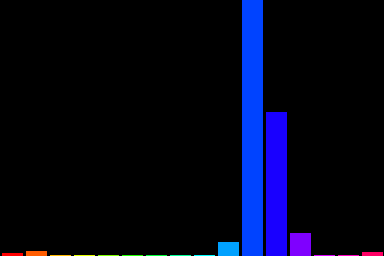

In [ ]:
# Transform the previous frame into HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# Creating an inRange mask for pixels
mask = cv2.inRange(hsv,np.array((0,64,32)), np.array((180,200,200)))
# Compute the histogram of the frame (use only the HUE channel). See `https://bit.ly/3pdVUEd`
# Take into account only pixels which are not too bright and not too dark (use the previous mask)
# Use 16 bins and speicfy the range of the hue ([0, 180])
hist = cv2.calcHist([hsv],[0], mask, [16], [0,180])
# Normalize the histogram between 0 (lowest intensity) and 255 (highest intensity) (use MinMax normalization `cv.NORM_MINMAX`) using the method `https://bit.ly/3jMGhCj`
hist = cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
# Reashape the histogram into a 1-D array (use `.reshape(-1)`)
hist = hist.reshape(-1)
# Show the histogram
show_hist(hist)

## Importing models


For the classifier we can use choose between the model trained in task 7 or task 9

In [ ]:
# Import trained model from task 7
cnn_model = tf.keras.models.load_model(cnn_model_path)

# Show the model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0

In [ ]:
# Import trained model from task 9
vgg_model = tf.keras.models.load_model(vgg_model_path)

# Show the model architecture
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (Functiona (None, 4096)              139570240 
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 143,768,643
Trainable params: 4,198,403
Non-trainable params: 139,570,240
_________________________________________________________________


## Erasing face detection, detecting hand and classifying letter

In the code below we remove the face detection to focus only on the hand detection. In order to do it we are gonna apply the CAM Shift algorithm to detect the face and erase it by setting probability 0 in the whole bounding box area of the face. Once done, we use CAM Shift again to detect the hand (now it will be the section with more density of probability in the image) and plot a bounding box around it.

Once we detect the hand, we are going to use the images as input data for our trained model to detect the letter.

As mentioned in the README section, the script needs of the following interaction with the user:


1.   Firstly, it will ask the user to choose between the model trained in task 7 (**cnn**) or the model trained in task 9 (**vgg**)

2.   Sencondly, the user must show his hand on camera and the script will ask to **confirm if the bounding box correctly detected the hand**.

3.  Once it is confirmed, the script will show the predicted letter **in screen**.



In [ ]:

VideoCapture()
eval_js('create()')
# Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

byte = eval_js('capture()')
im_width, im_height = im.shape[1],im.shape[0]
im = b64_to_bytes(byte)

tracking_window_hand = (0,0,im_width,im_height) # Define the initial tracking window for the hand. It spans the entire caption
already_defined_box = False # Auxiliar variable that checks if the hand box is well defined
done_A, done_B, done_C = False, False, False # Auxiliar variables to manage the creation of the dataset
img_count = 0 # Auxiliar variable to count the images created

img_dim = 32 # Final dimension of image
gray_scale = True # Gray scale image
channels = 1
selected_model = False
model = cnn_model

while True:

  if not selected_model:
    res = input("PLEASE, SELECT THE MODEL TO TEST [cnn or vgg]:")
    if res == "cnn":
      img_dim = 32
      gray_scale = True
      channels = 1
      model = cnn_model
      selected_model = True

    elif res == "vgg":
      img_dim= 224
      gray_scale = False
      channels = 3
      model = vgg_model
      selected_model = True
    
    else:
      print("PLEASE, SELECT A VALID MODEL")
      selected_model = False
  
  else:
    byte = eval_js('capture()')
    im = b64_to_bytes(byte)
    # Transform the image into HSV
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    
    # Compute the standard not too bright not too dark mask
    mask = cv2.inRange(hsv, np.array((0., 64., 32.)), np.array((180., 200., 200.)))

    # Back project the histogramm on the hsv img
    prob = cv2.calcBackProject([hsv],[0], hist, [0,180], scale=1)

    # Apply the mask
    prob = prob & mask

    # First look up for the face using cam shift starting from `tracking_window_face`
    (x,y,w,h) = tracking_window_face
    bbox, tracking_window_face = cv2.CamShift(prob, tracking_window_face, term_crit)

    # Retrieve the rotated bounding rectangle
    pts = cv2.boxPoints(bbox).astype(np.int)

    # Scale the rotated bounding box 1.5x times to eliminate detected parts outside the box 
    scaled_pts = scale_contour(pts, 1.5, 1.5)

    # Fill the rotated face bounding box with 0 in the prob map using`cv2.fillPoly`
    cv2.fillPoly(prob, [scaled_pts], 0)

    # Draw the boundix box around the face
    cv2.polylines(im, [scaled_pts], True, (255, 255 , 0), 2)

    # Now look up for the hand using cam shift starting from `tracking_window_hand`
    bbox, tracking_window_hand = cv2.CamShift(prob, tracking_window_hand, term_crit)

    pts = cv2.boxPoints(bbox).astype(np.int)

    # Scale the contour around the hand
    pts = scale_contour(pts, 1.5, 1.5)

    #Creating box around cam shift leaned box
    hand_box = get_hand_box(pts, im_width, im_height)

    cv2.rectangle(im, hand_box[0], hand_box[1], (255,255,0), 2)

    #Checks if the hand box is in the right positiom before taking samples, needs human interaction
    if not already_defined_box:
      eval_js('showimg("{}")'.format(bytes_to_b64(im)))
      response = input("Is the hand box right positioned? [y or n]:")
      if response == 'y':
        already_defined_box = True
    
    else:
      if gray_scale:
        #Converting image into black and white
        hand = cv2.cvtColor(im[hand_box[0][1]:hand_box[1][1], hand_box[0][0]:hand_box[1][0]], cv2.COLOR_BGR2GRAY)
      else:
        hand = im[hand_box[0][1]:hand_box[1][1], hand_box[0][0]:hand_box[1][0]]

      #Resizing image
      hand = cv2.resize(hand, (img_dim,img_dim))
      hand_input_format = hand.reshape(-1,img_dim,img_dim,channels)

      prediction = model.predict(hand_input_format)
      prediction = prediction.argmax()
      predicted_letter = chr(ord('A') + prediction)

      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(im,predicted_letter,(15,425), font, 2,(0,255,0),3)

    eval_js('showimg("{}")'.format(bytes_to_b64(im)))

<IPython.core.display.Javascript object>

PLEASE, SELECT THE MODEL TO TEST [cnn or vgg]:cnn
Is the hand box right positioned? [y or n]:n
Is the hand box right positioned? [y or n]:cnn
Is the hand box right positioned? [y or n]:y


error: ignored